# Import 
We use the `mlcolvar` and `ase` tools

In [1]:
import torch
import lightning as pl
import numpy as np
import matplotlib.pyplot as plt

from mlcolvar.cvs import DeepTDA
from mlcolvar.data import DictDataset,DictModule
from mlcolvar.core.transform import EigsAdjMat,SwitchingFunctions,ContHist,Statistics,Normalization
from mlcolvar.core.transform.utils import compute_adjacency_matrix
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics

from ase.io import read

torch.set_default_dtype(torch.float32)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data
This is meant to load `lammps` trajectory files `.lammpstrj`

NB. For simplicity, in this example notebook we use very few data points 

In [6]:
n_atoms = 512 # number of atoms
n_data = 10 # number of data to be loaded
states_num = 2 # number of states

# RINGS
# file names for ring phase
files = ['EXAMPLE_training_data/rings/PhaseI-NVT_S512_550K/dump.0.lammpstrj', 'EXAMPLE_training_data/rings/PhaseI-NVT_S512_650K/dump.0.lammpstrj', 'EXAMPLE_training_data/rings/PhaseI-NVT_S512_750K/dump.0.lammpstrj']
for i in range(len(files)):
    file = files[i]
    atoms = read(file, index=f'0:{n_data}')
    # atoms = read(file, index=f'0:{n_data*4}:4')
    tmp_pos = np.zeros((n_data, n_atoms, 3))
    for frame in range(n_data):
        tmp_pos[frame, :, :] = np.array(atoms[frame].get_positions())
    tmp_pos = np.reshape(tmp_pos, (n_data, n_atoms*3))
    if i==0:
        pos_A = np.copy(tmp_pos)
    else:
        pos_A = np.vstack((pos_A, tmp_pos))

cell = np.array(atoms[0].get_cell())[0,0]

# POLYMER
# file names for polymer phase
files = ['EXAMPLE_training_data/polymer/PhaseII-NVT_S512_550K/dump.0.lammpstrj', 'EXAMPLE_training_data/polymer/PhaseII-NVT_S512_650K/dump.0.lammpstrj', 'EXAMPLE_training_data/polymer/PhaseII-NVT_S512_750K/dump.0.lammpstrj']
for i in range(len(files)):
    file = files[i]
    atoms = read(file, index=f'0:{n_data}')
    # atoms = read(file, index=f'0:{n_data*4}:4')
    tmp_pos = np.zeros((n_data, n_atoms, 3))
    for frame in range(n_data):
        tmp_pos[frame, :, :] = np.array(atoms[frame].get_positions())
    tmp_pos = np.reshape(tmp_pos, (n_data, n_atoms*3))
    if i==0:
        pos_B = np.copy(tmp_pos)
    else:
        pos_B = np.vstack((pos_B, tmp_pos))


# We concatenate everything
lab_A, lab_B = np.zeros(len(pos_A)), np.zeros(len(pos_A)) + 1

pos, lab = np.concatenate((pos_A, pos_B)), np.concatenate((lab_A, lab_B))

# move to cell coords
pos = pos / cell

# move to torch tensors
pos, lab, cell = torch.Tensor(pos), torch.Tensor(lab), torch.Tensor([cell])

# create dataset
dataset = DictDataset(data=pos, labels=lab)

# Preprocessing
The input of the model are directly the atomic positions. From there, we compute the adiacency matrix and its eigenvalues distribution.

We do that as a preprocessing step in the `mlcolvar` framework so we can do it only once and save a lot of time in the optimization loop.

In [7]:
cutoff = 2.6 # cutoff distance for the adjacency matrix

# initialize the switching function object to have continuous and stable derivatives for the adjacency matrix
switching_function=SwitchingFunctions(in_features=n_atoms*3, name='Fermi', cutoff=cutoff,  options = {'q': 0.25})

# initialize the transform object from mlcolvar that computes the eigenvalues of the adiaceny matrix from the positions
eigs_adj_mat = EigsAdjMat(mode = 'continuous',
                            cutoff = cutoff, 
                            n_atoms = n_atoms,
                            PBC = True,
                            real_cell = cell,
                            scaled_coords = True,
                            switching_function=switching_function)

# initialize the transform object from mlcolvar that computes a continuous histogram using a guassian expansion
hist_eigs = ContHist(in_features = n_atoms,
                     min = -2.2, 
                     max = 2.2, 
                     bins = 100,
                     sigma_to_center = 2)

# concatenate the preprocessing module in a torc.nn.Sequential object
preprocessing = torch.nn.Sequential(eigs_adj_mat, hist_eigs)

### Quickly check switching function and preprocessing derivatives
Too sharp switching function may lead to numerical instabilites!

Nans in switching function's derivatives:  False
Nans in preprocessing's derivatives (ring phase):  False
Nans in preprocessing's derivatives (polymer phase):  False


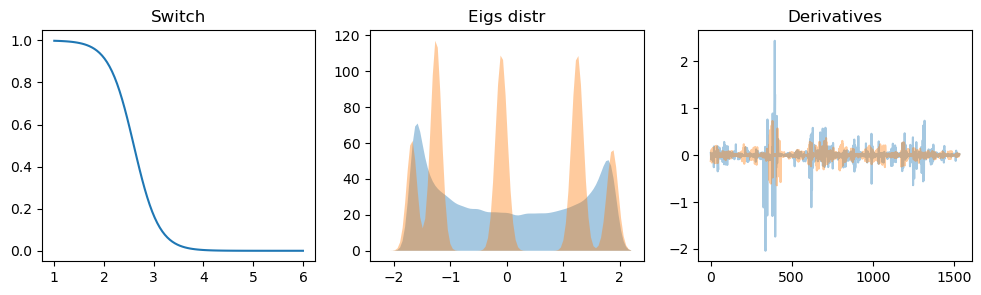

In [8]:
input = torch.linspace(1, 6, 100)
input.requires_grad = True
out = switching_function(input)

fig, ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(input.detach(), out.detach())
ax[0].set_title('Switch')
der = torch.autograd.grad(torch.sum(out), input )
print("Nans in switching function's derivatives: ", torch.isnan(der[0]).any().item())


input = torch.Tensor(pos[-1])
input.requires_grad = True
out = preprocessing(input)
der = torch.autograd.grad(torch.sum(out), input )
ax[2].plot(der[0].detach(), alpha=0.4)
ax[2].set_title('Derivatives')
ax[1].fill_between(np.linspace(-2.2,2.2,100), 0, out[0].detach(), alpha=0.4)
ax[1].set_title('Eigs distr')
print("Nans in preprocessing's derivatives (ring phase): ", torch.isnan(der[0]).any().item())

input = torch.Tensor(pos[1])
input.requires_grad = True
out = preprocessing(input)
der = torch.autograd.grad(torch.sum(out), input )
ax[2].plot(der[0].detach(), alpha=0.4)
ax[1].fill_between(np.linspace(-2.2,2.2,100), 0, out[0].detach(), alpha=0.4)
print("Nans in preprocessing's derivatives (polymer phase): ", torch.isnan(der[0]).any().item())
plt.show()

### We apply the preprocessing on smaller batches in the dataset to be safer with memory
In this example, as we have only few points, it is not necessary, but it is for larger datasets

In [9]:
prep_batch = 10
for i in range(6):
    print(i, end=' ')
    tmp = preprocessing(dataset['data'][i*prep_batch:(i+1)*prep_batch])
    if i==0:
        prep_data = tmp
    else:
        prep_data = torch.vstack((prep_data, tmp))
prep_data.shape

0 1 2 3 4 5 

torch.Size([60, 100])

### Create new datasets with the preprocessed data

In [19]:
prep_dataset = DictDataset(data=prep_data, labels=dataset['labels'])
prep_datamodule = DictModule(prep_dataset, lengths=[0.80, 0.20])

# Initialize model

In [20]:
nn_args = {'activation': 'relu'}
opt_args = {'lr': 0.001}
options = {'nn': nn_args, 'optimizer': opt_args, 'norm_in': None}

target_centers = [-25, 25]
target_sigmas = np.ones(2) * 0.2

model = DeepTDA(n_states=states_num,
                n_cvs=1,
                target_centers=target_centers,
                target_sigmas=target_sigmas, 
                layers=[100,64,32,1], 
                options=options)

metrics = MetricsCallback()
trainer = pl.Trainer(accelerator='cuda', callbacks=[metrics], max_epochs=400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Fit model

In [21]:
trainer.fit(model, prep_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | In sizes | Out sizes
---------------------------------------------------------------
0 | loss_fn | TDALoss     | 0      | ?        | ?        
1 | nn      | FeedForward | 8.6 K  | [100]    | [1]      
---------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 50.71it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 42.22it/s, v_num=4]


### Check training metrics

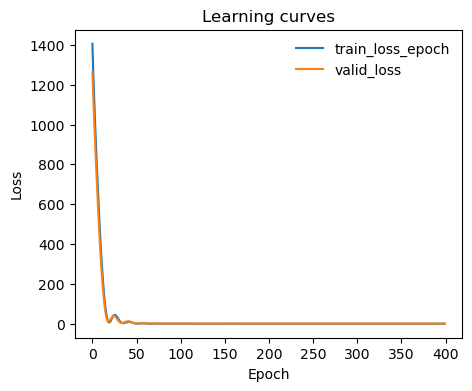

In [22]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Check model

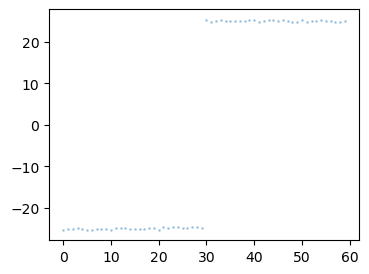

In [24]:
test = model(prep_dataset['data'])
fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(np.arange(0,60, 1), test.detach().numpy(), s=1, alpha=0.3)
plt.show()

### Export model

In [27]:
input = torch.Tensor(dataset['data'][0])
prep_input = torch.Tensor(prep_data[0])

model.preprocessing = None
print('Output from preprocessed data: ', model(prep_input))
model.preprocessing = preprocessing
print('Output applying preprocessing: ', model(input))

traced = model.to_torchscript(file_path='model_example_512.pt', method='trace', example_inputs=input)
loaded_model = torch.jit.load('model_example_512.pt')
print('Output from torchscript model: ', loaded_model(input))

Output from preprocessed data:  tensor([-25.2679], grad_fn=<AddBackward0>)
Output applying preprocessing:  tensor([[-25.2679]], grad_fn=<AddmmBackward0>)
Output from torchscript model:  tensor([[-25.2679]], grad_fn=<AddmmBackward0>)


### Generate plumed positions input file

In [42]:
n_atoms = 512
arg_string=''

with open('training_512/plumed_positions.dat', 'w') as f:
    f.write('#vim: ft=plumed\n')
    f.write('\n')
    f.write('# PLUMED input file scaled positions for DeepTDA cv based on adiacency matrix eigenvalues\n')
    f.write(f'# We simulate {n_atoms} atoms \n')
    
    # coord number loop
    f.write('\n')
    f.write('### Define positions\n')
    for i in range(1,n_atoms+1):
        f.write(f'p{int(i)}: POSITION ATOM={int(i)} SCALED_COMPONENTS\n')
        if i==n_atoms:
            arg_string = arg_string + f'p{int(i)}.a,p{int(i)}.b,p{int(i)}.c'
        else:
            arg_string = arg_string + f'p{int(i)}.a,p{int(i)}.b,p{int(i)}.c,'
    f.write(f'\n\n# ARG={arg_string}')
